# Training and evaluation notebook for wideResNet based Brevis Model.
<HR>
Models are trained on the CIFAR10 dataset, and uses CIFAR100 as an OOD dataset. <br>
    2 models are trained, one with branches using BrevisEnergy Loss and one using Cross entropy for all exits. <br>
    
    


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
import numpy as np
import sys
import os
from keras_flops import get_flops 
from skimage.filters import gaussian as gblur
from PIL import Image as PILImage

sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate
import tensorflow_probability as tfp
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

### load datasets

<hr>

In [2]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 10,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [3]:
# import tensorflow_datasets as tfds
# ds = tfds.load('svhn_cropped', split='train', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
train_ds100, test_ds100, validation_ds100 = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(label_mode="fine"),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


## Initialize functions for building the loss functions 
<hr>

In [4]:
class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1):
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = tf.reduce_min([self.max_t, tf.cast(epoch+self.start_val, tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)

class growth_update(lambda_update):
    ''' callback update method that checks the performance of the model against the validation set to decide if the annealing coef should be increased.
        provides greater control of the additional loss elements by updating their hyperparameters inteligently, rather then with only a preset schedule.
        
    '''
    def __init__(self, annealing_max,  lambda_t=0, max_t=1, starting_epoch = 0):
        self.starting_epoch = starting_epoch
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.step = tf.Variable(initial_value = 0,dtype=tf.float32)
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)
        self.training = tf.Variable(initial_value=False, dtype=tf.bool)              
        self.past_val_acc= tf.Variable(initial_value =0, dtype=tf.float32)
        self.val_acc= tf.Variable(initial_value =0, dtype=tf.float32)
        
    def on_training_begin(self, logs={}):
        ''' indicate that training has begun, so val growth is an option.
        '''
        tf.print("training commenced, validation growth enabled")
        self.training.assign(True)
    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = self.lambda_t
        if epoch >= self.starting_epoch:
            if self.val_acc >= self.past_val_acc:
                val = tf.reduce_min([self.max_t, tf.cast((self.step - self.starting_epoch) +self.start_val , tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
                tf.print("annealing coef updated to:", val)
                self.lambda_t.assign(val)
                self.past_val_acc.assign(self.val_acc)
                self.step.assign(self.step + 1)
            else:
                tf.print("val acc did not improve from {}, annealing coef not updated, remains at:{}".format(self.past_val_acc.numpy(), val.numpy()))
    def on_test_end(self, logs=None):
        """ if training, save the performance results
        """
        self.val_acc.assign(logs.get('branch_exit_accuracy')+logs.get('branch_exit_1_accuracy'))
        

In [5]:
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    return kl

def _KL(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    '''
    New KL divergence function. 
    '''
    target_alphas = tf.cast(target_alphas,tf.float32)
    alphas = tf.cast(alphas,tf.float32)
    if not precision:
        precision = tf.reduce_sum(alphas, axis=1, keepdims=True)
    if not target_precision:
        target_precision = tf.reduce_sum(target_alphas, axis=1, keepdims=True)
    precision = tf.cast(precision,tf.float32)
    target_precision = tf.cast(target_precision,tf.float32)
    
    precision_term = tf.compat.v1.lgamma(target_precision) - tf.compat.v1.lgamma(precision)
    alphas_term = tf.reduce_sum(
        tf.compat.v1.lgamma(alphas + epsilon)
        - tf.compat.v1.lgamma(target_alphas + epsilon)
        + (target_alphas - alphas)
        * (
            tf.compat.v1.digamma(target_alphas + epsilon)
            - tf.compat.v1.digamma(target_precision + epsilon)
        ),
        axis=1,
        keepdims=True,
    )
    cost = tf.squeeze(precision_term + alphas_term)
    return cost

def reverse_kl(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    return _KL(target_alphas,alphas, precision=None, target_precision=None, epsilon=1e-8)

def DirichletKLLoss(labels, logits, reverse=True):
    # alpha = tf.exp(logits)
    alpha = tf.exp(tf.clip_by_value(logits/10,-10,10))
    target_concentration = tf.reduce_sum(alpha,axis=1,keepdims=True)
    target_alphas = (tf.ones_like(alpha) + (target_concentration * labels))
    alpha = alpha + 1
    if reverse:
        cost = reverse_kl(alpha, target_alphas)
    else:
        cost = _KL(alpha, target_alphas)
    if tf.math.is_nan(tf.reduce_sum(cost)):
        tf.print("logits",logits, summarize=-1)
        tf.print("alpha",alpha, summarize=-1)
        tf.print("cost", cost, summarize=-1)
    return cost

In [6]:
from scipy.special import logsumexp

def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 
        annealing_coef =  lambda_callback.lambda_t
        annealing_coef =  0.0001
        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(p,alpha)
        return (A + B) + C
    return custom_loss_function


def brevisEnergy(lambda_callback: lambda_update):
    ''' Proposed Loss function for BrevisNet branch classifiers
        consists of the expected mean square error loss + reverse dirichlet KL + regularizing dirichlet entropy mean
    '''
    def brevisEnergy(p, logits):
        evidence = tf.exp(logits)
        # evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        alp = E*(1-p) + 1 
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy()) ###entropy of the dirichlet distribution as a smoothing regularizer. 
        return (A+B) + C + D
    return  brevisEnergy


## Build the Model
<hr>

In [8]:
# ### from scratch model

import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
# model.save('./models/cifaroutlier_EDL_adam.hdf5')
# loss = kl_loss(lambda_callback)
# loss = brevisEnergy(lambda_callback)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)

earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)

# _base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(224, 224, 3),
#      weights='imagenet',include_top=False)

# x = _base_model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(1024, activation="relu")(x)
# x = tf.keras.layers.Dense(512, activation="relu")(x)
# x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

# base_model = tf.keras.models.Model(inputs=_base_model.input, outputs=x)
# base_model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
#               loss=loss,
#               metrics=['accuracy'])
# history = base_model.fit(train_ds, validation_data=validation_ds, epochs=30,callbacks=[lambda_callback,earlyStop])


base_model = keras.models.load_model("./models/wideresnet_.81.hdf5")
base_model.compile(#optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              tf.keras.optimizers.Adam(),
              # tf.optimizers.SGD(lr=0.001, momentum=0.9)
              loss=loss,
              metrics=['accuracy'])
base_model.fit(train_ds, validation_data=validation_ds, epochs=40, callbacks=[earlyStop])
# base_model.evaluate(test_ds)


Epoch 1/40
1407/1407 [==============================] - 227s 159ms/step - loss: 0.6782 - accuracy: 0.8883 - val_loss: 0.9877 - val_accuracy: 0.7932
Epoch 2/40
1407/1407 [==============================] - 224s 159ms/step - loss: 0.6444 - accuracy: 0.8974 - val_loss: 0.8523 - val_accuracy: 0.8270
Epoch 3/40
1407/1407 [==============================] - 224s 159ms/step - loss: 0.6387 - accuracy: 0.8974 - val_loss: 0.8709 - val_accuracy: 0.8240
Epoch 4/40
1407/1407 [==============================] - 225s 160ms/step - loss: 0.6284 - accuracy: 0.9011 - val_loss: 0.7927 - val_accuracy: 0.8446
Epoch 5/40
1407/1407 [==============================] - 225s 160ms/step - loss: 0.6145 - accuracy: 0.9049 - val_loss: 0.9599 - val_accuracy: 0.8142
Epoch 6/40
1407/1407 [==============================] - 226s 161ms/step - loss: 0.6129 - accuracy: 0.9056 - val_loss: 0.8436 - val_accuracy: 0.8410
Epoch 7/40
1407/1407 [==============================] - 226s 161ms/step - loss: 0.6085 - accuracy: 0.9069 - val_

In [12]:
base_model.save("./models/wideresnet_.ES.hdf5")

In [15]:
base_model.evaluate(test_ds)

313/313 [==============================] - 14s 46ms/step - loss: 0.9237 - accuracy: 0.8163


[0.923727810382843, 0.8162999749183655]

In [13]:
model = keras.models.load_model("./models/wideresnet_.81.hdf5")

In [14]:
model.evaluate(test_ds)

313/313 [==============================] - 15s 45ms/step - loss: 1.0274 - accuracy: 0.8118


[1.0274261236190796, 0.8118000030517578]

In [8]:
base_model.summary()
# Calculae FLOPS
print(base_model.outputs)
flops = get_flops(base_model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_84 (Conv2D)             (None, 32, 32, 16)   432         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_75 (BatchN  (None, 32, 32, 16)  64          ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_75 (Activation)     (None, 32, 32, 16)   0           ['batch_normalization_75[0]

## Branch the model
First we will train the BrevisNet version of the model with BrevisEnergy loss
<hr>

In [7]:
def _branch_flat(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
    branchLayer = layers.Dense(1024, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch1024"))(branchLayer)
    branchLayer = layers.Dense(512, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch512"))(branchLayer)
    # output = branch.CrossEntropyEndpoint(targets.shape[-1], name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer, targets)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=160, kernel_size=(3,3), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=160, kernel_size=(3,3), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=360, kernel_size=(3,3), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.AveragePooling2D( pool_size=(10,10), strides=(1,1), padding='valid',name=tf.compat.v1.get_default_graph().unique_name("branch_avgpool"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    # branchLayer = layers.Dense(2048,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    # branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=320, kernel_size=(3,3), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=320, kernel_size=(3,3), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=440, kernel_size=(3,3), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.AveragePooling2D( pool_size=(4,4), strides=(1,1), padding='valid',name=tf.compat.v1.get_default_graph().unique_name("branch_avgpool"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    # branchLayer = layers.Dense(2048,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    # branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output




In [8]:

def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv1_SM(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, activation='softmax', name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2_SM(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, activation='softmax', name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

In [9]:

def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output



In [10]:
from tensorflow.python.platform import tf_logging as logging
class _earlyStopping(keras.callbacks.EarlyStopping):
    def __init__(self,
               monitor='val_loss',
               min_delta=0,
               patience=0,
               verbose=0,
               mode='auto',
               baseline=None,
               restore_best_weights=False):
        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.baseline = baseline
        self.min_delta = abs(min_delta)
        self.wait = 0
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        # super(_earlyStopping, self).__init__(monitor=)
        if mode not in ['auto', 'min', 'max']:
            logging.warning('EarlyStopping mode %s is unknown, '
                          'fallback to auto mode.', mode)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            
            # if (self.monitor.endswith('acc') or self.monitor.endswith('accuracy') or self.monitor.endswith('auc')):
            self.monitor_op = np.greater
            # else:
                # self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

        self.monitor_op = np.greater
        self.min_delta *= 1
        
    def get_monitor_value(self, logs):
        logs = logs or {}
        monitor_value = 0
        if type(self.monitor) is list:
            for i in self.monitor:
                _log_val = logs.get(i)
                # logging.warning("values are {}, {}".format(i,_log_val))
                if _log_val is None:
                    logging.warning('Metric `%s` '
                          'for early stopping is not available. Available metrics are: %s',
                          i, ','.join(list(logs.keys())))
                else:
                    monitor_value += _log_val
        # monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            logging.warning('Early stopping conditioned on metric `%s` '
                          'which is not available. Available metrics are: %s',
                          self.monitor, ','.join(list(logs.keys())))
        return monitor_value


In [11]:
# import random
# seed = 42
# random.seed(seed)
# tf.random.set_seed(seed)
# np.random.seed(seed)
tf.keras.backend.clear_session()


def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        
        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        
        # annealing_coef =  0.0001
        # alp = E*(1-p) + 1 
        # C =   annealing_coef * KL(alp,10)
        # C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # tf.print((A + B),summarize=-1)
        # tf.print((info_reg + D),summarize=-1)
        
        # tf.print(((A + B) + info_reg + D).shape)
        return (A + B) + info_reg +  D # info_reg + D  #+ info_reg #+ C + D
    return custom_loss_function

        
earlyStop = _earlyStopping(monitor=["val_dense_3_accuracy","val_branch_exit_accuracy","val_branch_exit_1_accuracy"],patience=5,restore_best_weights=True)
growth_callback = growth_update(100,0.,max_t = 1, starting_epoch =0)

branch_loss = loss_wrapper(growth_callback)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
CE_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model = brevis.BranchModel(name="./models/wideresnet_.ES.hdf5", custom_objects={})
model.add_branches([_branch_conv1,_branch_conv2],
                          ["activation_83","activation_91",#"mixed6"
                          ],
                          target_input=False,loop=False,num_outputs=10)

model.setTrainable(True)
# model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
#                   optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#                   # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
#                metrics=['accuracy'])

model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
               metrics=['accuracy'])



# model.compile(loss=[trunk_loss,trunk_loss,trunk_loss], 
#                   # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
#                   # optimizer="adam",
#                metrics=['accuracy'])

# model.summary()
# model.fit(train_ds, epochs = 10, validation_data=validation_ds, transfer=True,callbacks=[growth_callback])

Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  activation_83
add Branch to branch point  activation_91
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_3')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x000001895F33D0C8>
Freezing Main Layers and setting branch layers training to true

preset: Other


In [12]:
model.outputs

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_3')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]

In [13]:
model.fit(train_ds, epochs = 60, validation_data=validation_ds, transfer=True,callbacks=[growth_callback,earlyStop])

Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0
Epoch 1/60
1407/1407 [==============================] - 122s 82ms/step - loss: 1.6249 - dense_3_loss: 0.2638 - branch_exit_loss: 0.5712 - branch_exit_1_loss: 0.4477 - dense_3_accuracy: 0.9114 - branch_exit_accuracy: 0.5614 - branch_exit_1_accuracy: 0.6644 - val_loss: 1.5642 - val_dense_3_loss: 0.4505 - val_branch_exit_loss: 0.4452 - val_branch_exit_1_loss: 0.3264 - val_dense_3_accuracy: 0.8446 - val_branch_exit_accuracy: 0.6764 - val_branch_exit_1_accuracy: 0.7690
annealing coef updated to: 0.01
Epoch 2/60
1407/1407 [==============================] - 114s 81ms/step - loss: 1.3571 - dense_3_loss: 0.2638 - branch_exit_loss: 0.4037 - branch_exit_1_loss: 0.3474 - dense_3_accuracy: 0.9114 - branch_exit_accuracy: 0.7580 - branch_exit_1_accuracy: 0.7945 - val_loss: 1.5973 - val_dense_3_loss: 0.4505 - val_branch_exit_loss: 0.4692 - val_branch_exit_1_loss: 0.3354 - val_dense_3_accuracy: 0.8446 - val_bra

In [14]:
model.save("./models/journal_models/wideresnet_EDL_ExtraT_ES.hdf5")

In [11]:
model.fit(train_ds, epochs = 15, validation_data=validation_ds, transfer=False,callbacks=[growth_callback])

Setting Main Layers  and branch layers training to true
annealing coef updated to: 0
Epoch 1/15
1407/1407 [==============================] - 269s 187ms/step - loss: 3.2189 - dense_3_loss: 0.3611 - branch_exit_loss: 1.2905 - branch_exit_1_loss: 1.1825 - dense_3_accuracy: 0.8738 - branch_exit_accuracy: 0.5726 - branch_exit_1_accuracy: 0.6274 - val_loss: 2.4980 - val_dense_3_loss: 0.4179 - val_branch_exit_loss: 0.9597 - val_branch_exit_1_loss: 0.7394 - val_dense_3_accuracy: 0.8592 - val_branch_exit_accuracy: 0.6634 - val_branch_exit_1_accuracy: 0.7440
annealing coef updated to: 0.01
Epoch 2/15
1407/1407 [==============================] - 262s 186ms/step - loss: 2.1127 - dense_3_loss: 0.3035 - branch_exit_loss: 0.7207 - branch_exit_1_loss: 0.7105 - dense_3_accuracy: 0.8937 - branch_exit_accuracy: 0.7503 - branch_exit_1_accuracy: 0.7589 - val_loss: 2.5973 - val_dense_3_loss: 0.4651 - val_branch_exit_loss: 0.9849 - val_branch_exit_1_loss: 0.7674 - val_dense_3_accuracy: 0.8422 - val_branch_ex

In [30]:
#edl es was 18.
model.save("./models/journal_models/wideresnet_CE_ExtraT_ES.hdf5")

In [15]:
model.evaluate(test_ds)

313/313 [==============================] - 17s 55ms/step - loss: 1.9511 - dense_3_loss: 0.5815 - branch_exit_loss: 0.5973 - branch_exit_1_loss: 0.4302 - dense_3_accuracy: 0.8163 - branch_exit_accuracy: 0.7239 - branch_exit_1_accuracy: 0.8314


[1.9511430263519287,
 0.5815438628196716,
 0.5972588658332825,
 0.43015629053115845,
 0.8162999749183655,
 0.7239000201225281,
 0.8313999772071838]

In [17]:
# import random
# seed = 42
# random.seed(seed)
# tf.random.set_seed(seed)
# np.random.seed(seed)
tf.keras.backend.clear_session()


def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        
        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        
        # annealing_coef =  0.0001
        # alp = E*(1-p) + 1 
        # C =   annealing_coef * KL(alp,10)
        # C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # tf.print((A + B),summarize=-1)
        # tf.print((info_reg + D),summarize=-1)
        
        # tf.print(((A + B) + info_reg + D).shape)
        return (A + B) + info_reg +  D # info_reg + D  #+ info_reg #+ C + D
    return custom_loss_function

        
earlyStop = _earlyStopping(monitor=["val_dense_3_accuracy","val_branch_exit_accuracy","val_branch_exit_1_accuracy"],patience=5,restore_best_weights=True)
growth_callback = growth_update(100,0.,max_t = 1, starting_epoch =0)

branch_loss = loss_wrapper(growth_callback)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
CE_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model = brevis.BranchModel(name="./models/wideresnet_.81.hdf5", custom_objects={})
model.add_branches([_branch_conv1,_branch_conv2],
                          ["activation_83","activation_91",#"mixed6"
                          ],
                          target_input=False,loop=False,num_outputs=10)

# model.setTrainable(True)
# model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
#                   optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#                   # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
#                metrics=['accuracy'])

model.compile(loss=[trunk_loss,CE_loss,CE_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
               metrics=['accuracy'])



# model.compile(loss=[trunk_loss,trunk_loss,trunk_loss], 
#                   # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
#                   # optimizer="adam",
#                metrics=['accuracy'])

# model.summary()
# model.fit(train_ds, epochs = 10, validation_data=validation_ds, transfer=True,callbacks=[growth_callback])

Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  activation_83
add Branch to branch point  activation_91
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_3')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x0000027B2A562F48>


In [18]:
model.fit(train_ds, epochs = 60, validation_data=validation_ds, transfer=False,callbacks=[growth_callback,earlyStop])

Setting Main Layers  and branch layers training to true
annealing coef updated to: 0
Epoch 1/60
1407/1407 [==============================] - 299s 210ms/step - loss: 3.1836 - dense_3_loss: 0.3578 - branch_exit_loss: 1.2631 - branch_exit_1_loss: 1.1796 - dense_3_accuracy: 0.8745 - branch_exit_accuracy: 0.5796 - branch_exit_1_accuracy: 0.6329 - val_loss: 2.5053 - val_dense_3_loss: 0.4062 - val_branch_exit_loss: 0.9547 - val_branch_exit_1_loss: 0.7682 - val_dense_3_accuracy: 0.8616 - val_branch_exit_accuracy: 0.6730 - val_branch_exit_1_accuracy: 0.7366
annealing coef updated to: 0.01
Epoch 2/60
1407/1407 [==============================] - 294s 209ms/step - loss: 2.1002 - dense_3_loss: 0.3109 - branch_exit_loss: 0.7066 - branch_exit_1_loss: 0.7056 - dense_3_accuracy: 0.8933 - branch_exit_accuracy: 0.7547 - branch_exit_1_accuracy: 0.7594 - val_loss: 2.3524 - val_dense_3_loss: 0.4108 - val_branch_exit_loss: 0.8746 - val_branch_exit_1_loss: 0.6871 - val_dense_3_accuracy: 0.8590 - val_branch_ex

In [19]:
#edl es was 18.
model.save("./models/journal_models/wideresnet_CE_ES_2.hdf5")

In [17]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()
      

def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        
        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg )
        
        # annealing_coef =  0.0001
        alp = E*(1-p) + 1 
        # C =   annealing_coef * KL(alp,10)
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        return (A + B) + D  #+ info_reg #+ C + D
    return custom_loss_function   

        
def auxLoss(lambda_callback: lambda_update):
    def auxloss(p, logits):
        evidence = exp_evidence(logits)
            # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t

        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        
        alp = E*(1-p) + 1 
        # else:
            # tf.print("metric",annealing_coef)
        # C =   annealing_coef * KL(alp,10)
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # return (A + B) + C #+ D #+ info_reg #+ C + D
        # tf.print(info_reg)
        return tf.reduce_mean(info_reg+ D )
    return auxloss    

# branch_loss = brevisEnergy(lambda_callback)

growth_callback = growth_update(50,0.,max_t = 1, starting_epoch =0)

auxlossMetric = auxLoss(growth_callback)
branch_loss = loss_wrapper(growth_callback)


trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# loss = kl_loss(lambda_callback)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)


model = brevis.BranchModel(name="./models/wideresnet_.81.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv1,_branch_conv2],
                          ["activation_83","activation_91",#"mixed6"
                          ],
                          target_input=False,loop=False,num_outputs=10)
# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.setTrainable(True)
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])

# model.summary()
# model.fit(train_ds, epochs = 10, validation_data=validation_ds, transfer=True,callbacks=[growth_callback])

Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  activation_83
add Branch to branch point  activation_91
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_3')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x000001D8EA510EC8>
Freezing Main Layers and setting branch layers training to true


In [18]:
model.fit(train_ds, epochs = 15, validation_data=validation_ds, transfer=True,callbacks=[growth_callback])

Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0
Epoch 1/15
1407/1407 [==============================] - 108s 74ms/step - loss: 1.6774 - dense_3_loss: 0.3048 - branch_exit_loss: 0.5613 - branch_exit_1_loss: 0.4493 - dense_3_accuracy: 0.8967 - branch_exit_accuracy: 0.5688 - branch_exit_1_accuracy: 0.6640 - val_loss: 1.4336 - val_dense_3_loss: 0.3395 - val_branch_exit_loss: 0.4263 - val_branch_exit_1_loss: 0.3058 - val_dense_3_accuracy: 0.8802 - val_branch_exit_accuracy: 0.6868 - val_branch_exit_1_accuracy: 0.7886
annealing coef updated to: 0.02
Epoch 2/15
1407/1407 [==============================] - 103s 73ms/step - loss: 1.2873 - dense_3_loss: 0.3048 - branch_exit_loss: 0.3259 - branch_exit_1_loss: 0.2947 - dense_3_accuracy: 0.8967 - branch_exit_accuracy: 0.7729 - branch_exit_1_accuracy: 0.7953 - val_loss: 1.3887 - val_dense_3_loss: 0.3395 - val_branch_exit_loss: 0.4044 - val_branch_exit_1_loss: 0.2828 - val_dense_3_accuracy: 0.8802 - val_bra

In [21]:
model.save("./models/journal_models/wideresnet_edl_iar_15_g100.hdf5")

## Get the flop cost for each branch output

In [69]:
# model = brevis.BranchModel(name="./models/resnet50_finetuned_32.hdf5", custom_objects={})
# model.compile(loss=[trunk_loss], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="", metrics=['accuracy'])
# model.evaluate(test_ds)

In [30]:
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("dense_3").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 3.53 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
FLOPS: 7.15 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_3')>]
FLOPS: 10.7 G


In [28]:
# lambda_callback = lambda_update(1000,0,max_t = 0.01)
# model = tf.keras.models.load_model("./models/journal_models/inception_Brev_conv3_10.h5",custom_objects={"BranchModel":brevis.BranchModel,"brevisEnergy":brevisEnergy(lambda_callback)})
model = tf.keras.models.load_model("./models/journal_models/wideresnet_CE_ExtraT_ES.hdf5",custom_objects={"BranchModel":brevis.BranchModel,"custom_loss_function":loss_wrapper(growth_callback)})


preset: Other


In [29]:

def getPredictions_Energy(model, input_set, stopping_point=None,num_classes=10, values =['energy', 'entropy', 'calibration']):
    '''
        Function for collecting the model's predictions on a test set. 
        Returns a list of DataFrames for each exit of the model.    
    '''
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    print("outputs",num_outputs)
    print(values)
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Energy = []
    Energy_softmax = []
    Energy_evidence = []
    Energy_alpha = []
    Energy_Mass = []
    Entropy = []
    pAcc=[]
    calibration=[]

    conf=[]
    entropy_of_exp=[]
    expected_entropy=[]
    mutual_info=[]
    epkl=[]
    dentropy=[]
    if 'energy' in values:
        print(True)
    for i in range(num_outputs):
        Results.append([])
        Pred.append([])
        Labels.append([])
        Uncert.append([])
        Energy.append([])
        Energy_softmax.append([])
        Energy_evidence.append([])
        Energy_alpha.append([])
        Energy_Mass.append([])
        Entropy.append([])
        pAcc.append([])
        calibration.append([])

        conf.append([])
        entropy_of_exp.append([])
        expected_entropy.append([])
        mutual_info.append([])
        epkl.append([])
        dentropy.append([])
        
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        try:
            print("prediction: {} of {}".format(i,len(input_set)),end='\r')
        except:
            print("prediction: {}".format(i),end='\r')
            pass
        predictions = model.predict(x)
        if num_outputs > 1:
            _predictions = predictions[0]
        else:
            _predictions = [predictions]
        # print(_predictions)
        for k, outputs in enumerate(_predictions):
            
            # print("outputs ", k, outputs)
            for j, prediction in enumerate(outputs):
               
                Results[k].append(np.argmax(prediction))
                Labels[k].append(np.argmax(y[j]))
                
                if 'energy' in values:
                    Energy[k].append( -(logsumexp(np.array(prediction))))
                if 'entropy' in values:
                    Entropy[k].append(brevis.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                if 'calibration' in values:
                    calibration[k].append(np.amax(tf.nn.softmax(prediction).numpy()))
                if 'uncert' in values:
                    evidence =tf.nn.softplus(prediction)
                    alpha = evidence +1
                    S = sum(alpha)
                    E = alpha - 1
                    Mass = alpha / S
                    u = num_classes / S
                    Uncert[k].append(u.numpy().mean())
                # Entropy[k].append(brevis.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                # dirch = evaluate.dirichlet_prior_network_uncertainty([prediction])
                # # print(dirch)
                # conf[k].append(dirch["confidence_alea_uncert."])
                # entropy_of_exp[k].append(dirch["entropy_of_expected"])
                # expected_entropy[k].append(dirch["expected_entropy"])
                # mutual_info[k].append(dirch["mutual_information"])
                # epkl[k].append(dirch["EPKL"])
                # dentropy[k].append(dirch["differential_entropy"])
    Outputs=[]
    for j in range(num_outputs):
#         "probs":Pred[j],
        # df = pd.DataFrame({"x":Results[j],"y":Labels[j],'sum':Sum[j],'uncert':Uncert[j],"belief masses":Evidence[j]})
        results = {"x":Results[j],"y":Labels[j]}
        if 'energy' in values:
            results["energy"]=Energy[j]
        if 'entropy' in values:
            results['entropy']=Entropy[j]
        if 'calibration' in values:
            results['calibration']=calibration[j]
        if 'uncert' in values:
            results['uncert']=Uncert[j]
#         {"x":Results[j],"y":Labels[j],
#                         # "confidence_alea_uncert":conf[j],
#                         # "entropy_of_expected":entropy_of_exp[j],
#                         # "expected_entropy":expected_entropy[j],
#                         # "mutual_information":mutual_info[j],
#                         # "EPKL":epkl[j],
#                         # "differential_entropy":dentropy[j],
#                       }
        # print(results)
        df = pd.DataFrame(results)
        conditions = [df['x'] == df['y'],df['x'] != df['y']]
        choices = [1, 0]
        #create new column in DataFrame that displays results of comparisons
        df['correct'] = np.int32(np.select(conditions, choices, default=None))
        Outputs.append(df)
    return Outputs

## Get the Branch output results
Collect the branch output results for both the ID and OOD test sets then evaluate the results.

In [30]:
output_ID= getPredictions_Energy(model, test_ds,values=['entropy'],stopping_point=None)
for i in output_ID:
    i['outlier']=0


outputs 3
['entropy']


In [31]:
output_OOD = getPredictions_Energy(model, test_ds100,values=['entropy'],stopping_point=None)
for i in output_OOD:
    i['correct']=0
    i['outlier']=1

outputs 3
['entropy']


In [ ]:
# output_OOD_svhn = getPredictions_Energy(model, test_ds_svhn,stopping_point=313)
# output_OOD_svhn['correct']=0
# output_OOD_svhn['outlier']=1


In [ ]:
def save_outputs(filename,outputs):
    from openpyxl import Workbook
    wb= Workbook()
    ws=wb.active
    with pd.ExcelWriter('./csv/'+filename+'.xlsx', engine="openpyxl") as writer:
        writer.book=wb
        writer.sheets = dict((ws.title, ws) for ws in wb.worksheets)

        #useful code
        for i, df in enumerate(outputs):
            name = "exit{}".format(i+1)
            df.to_excel(writer, name)
        # df.to_excel(writer, sheet, ...)
        writer.save()
    wb.close()
    
def read_outputs(fileName):
    output_test = list(pd.read_excel('./csv/'+fileName+'.xlsx',['exit1','exit2','exit3']).values())
    # for i in output_test:
        # print(i.head())
    return output_test
filename = 'wideresnet_CE_10'
save_outputs(filename+'_ID',output_ID)
save_outputs(filename+'_OOD',output_OOD)
# save_outputs(filename+'_OOD_SVHN',output_OOD_SVHN)

In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt, argmax
def calc_AUC(output_df,metrics=['energy'],plot=False, pos_label = 0):
    '''
    AUC calculation function for list of output dataframes
    returns a list of threshold for the gmean of each set of outputs.    
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        print("metric", metric)
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()
    return _thresholds

def buildComparePlot(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics) is not list:
            metrics = [metrics]
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            Exit_Name=[]
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            # if main_exit_included:
            _ID.append(_ID.pop(0))
            _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            
            for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
                Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
                
                legend = ["threshold","correct","incorrect", "OOD"]
                Correct = output_ID.loc[(output_ID['correct'] == True)]
                Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                if plot:
                    _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                    _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                    _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram

                
                if threshold:
                    if type(threshold) is list:
                        if j >= len(threshold): #no threshold in the array so treat as None.
                            continue
                        _threshold = threshold[j]
                    else:
                        _threshold = threshold
                    if _threshold == "mean":
                        # _threshold = np.array(ID[metric]).mean()
                        Correct = output_ID.loc[(output_ID["correct"] == True)]
                        _threshold = np.array(Correct[metric]).mean()
                    if _threshold == "gmean":
                        print("m",metric)
                        AUC_thresholds = calc_AUC(output_ID, metrics=metric, plot = False)
                        _threshold = AUC_thresholds[j]
                    if _threshold == "PR_AUC":
                        precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                        _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                    else:
                        _threshold = np.float32(_threshold)

                if len(rollOver_ID_indices)>0:
                    # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                    output_ID = output_ID.iloc[rollOver_ID_indices]
                if len(rollOver_OOD_indices)>0:
                    # if plot:
                    # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                    output_OOD = output_OOD.iloc[rollOver_OOD_indices]
                    
                if plot:
                    plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                    plt.title(metric + " outliers")
                    plt.legend(legend)
                    plt.xlabel("entropy")
                    plt.ylabel("frequency")
                    plt.show()
                if main_exit_included and i == len(_ID)-1 :
                    Exit_Name.append("Main_exit")
                    _threshold
                    if plot:
                        print("main_exit")
                    OOD_accepted = output_OOD
                    OOD_rejected = None
                    ID_accepted = output_ID
                    ID_rejected = None
                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = None
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = None
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    _threshold = "NA"
                    ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                    # if metric in lessThanMetrics:
                        # _threshold = math.inf
                    # else:
                        # _threshold = -math.inf
                # print(_threshold)
                else:
                    if metric in lessThanMetrics: ## metrics that require less than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                    else: ### metrics that require greater than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                    rollOver_ID_indices = ID_rejected.index
                    rollOver_OOD_indices = OOD_rejected.index
                    if i >= len(exit_labels):
                        exit_labels.append("exit_{}".format(i+1))
                    print(exit_labels)
                    Exit_Name.append(exit_labels[i])
                Thresholds.append(_threshold)
                
                Results.append(accepted_correct + accepted_incorrect)
                Input_ID.append(len(output_ID))
                Input_OOD.append(len(output_OOD))
                Accepted_ID_list.append(len(ID_accepted))
                Accepted_OOD_list.append(len(OOD_accepted))
                Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted) + len(OOD_accepted)))
                Acceptance_correct.append(len(accepted_correct))
                Accepted_Accuracy_list.append(overall_accepted_acc)
            df = pd.DataFrame({
            "Exit_Name":Exit_Name,
            "ID_Inputs":Input_ID,
            "OOD_Inputs":Input_OOD,
            "Test_Accuracy":Test_accuracy,
            # "RollOver_Accuracy":Rollover_accuracy,
            "Threshold":Thresholds,
            "Accepted ID":Accepted_ID_list,
            "Accepted OOD":Accepted_OOD_list,
                
            "Accepted_Correct":Acceptance_correct,
            "Accepted_ID_Ratio":Accepted_Ratio_list,
            "Acceptance_Accuracy":Accepted_Accuracy_list,

            # "Flops":Branch_flops,
            # "Cost Ratio":,                                  
                          })
            with pd.option_context('expand_frame_repr', False):
                print (df)


### ID/OOD branch performance
<hr>

In [29]:
#CE es
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)

metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.18048839543530176 Best Threshold=0.08328880369663239, G-Mean=0.746453266928924, TPR=0.7744163104242026, FPR=0.2805000718494037
['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.14303004920722304 Best Threshold=0.5033168196678162, G-Mean=0.7814231782952162, TPR=0.8163493840985442, FPR=0.252008765522279
['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.13485858599831452 Best Threshold=3.240971803665161, G-Mean=0.7946032131877769, TPR=0.8292547274749722, FPR=0.23860034138015118
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6959  0.083289         5694          2864              5007           0.665342             0.585067
1     exit_2       4306        7136         0.8214  0.503317         1918          1315              1733           0.5932

In [27]:
#EDL es
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.20145986774623492 Best Threshold=-31.09141731262207, G-Mean=0.7272401739380328, TPR=0.7848605577689243, FPR=0.32615002072109406
['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.13186150588225892 Best Threshold=-75.5687026977539, G-Mean=0.7927039477245751, TPR=0.8155397390272835, FPR=0.22949242242001444
['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.1460508204132312 Best Threshold=-2.444079875946045, G-Mean=0.7852319061190286, TPR=0.804028307022319, FPR=0.23312507656498835
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7239 -31.091417         5473          2462              4878           0.689729             0.614745
1     exit_2       4527        7538         0.8314 -75.568703         2214          1442              2020           0.605580    

In [29]:
#EDL es
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.19602473826803785 Best Threshold=-40.40770721435547, G-Mean=0.7307263173207532, TPR=0.7875264270613108, FPR=0.32197710136833285
['exit_1']
m energy
metric energy
energy  lr_auc 0.14339485394530238 Best Threshold=-61.21457290649414, G-Mean=0.7788093369613007, TPR=0.826608505997819, FPR=0.266225814352192
['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15272446609114917 Best Threshold=-2.4557576179504395, G-Mean=0.7728372610411698, TPR=0.8432518597236982, FPR=0.2916974624291698
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7162 -40.407707         5460          2369              4856           0.697407             0.620258
1     exit_2       4540        7631         0.8166 -61.214573         2018          1361              1819           0.597218             0

In [22]:
#CE es
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)

metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.18607109027527347 Best Threshold=0.06010536849498749, G-Mean=0.7404830734819228, TPR=0.7738983050847458, FPR=0.29148936170212764
['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.13606061881861697 Best Threshold=0.40642714500427246, G-Mean=0.7921012482592173, TPR=0.841589861751152, FPR=0.25447725072604066
['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.13862376697223083 Best Threshold=3.2307209968566895, G-Mean=0.7876306627335631, TPR=0.8490453460620525, FPR=0.2693416626621816
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7050  0.060105         5663          2685              4995           0.678366             0.598347
1     exit_2       4337        7315         0.8264  0.406427         1948          1418              1795           0.

In [18]:
#CE es
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)

metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.18508619542085095 Best Threshold=0.33505114912986755, G-Mean=0.742391893205918, TPR=0.8117883456128601, FPR=0.3210721414314229
['exit_1']
m entropy
metric entropy
entropy  lr_auc 0.14759452330109282 Best Threshold=0.6346042156219482, G-Mean=0.7825698153078396, TPR=0.8504168710152036, FPR=0.27986433865092325
['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.12934604544574152 Best Threshold=3.2438595294952393, G-Mean=0.7981188478112202, TPR=0.8223564954682779, FPR=0.22540443379269023
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7014  0.335051         5325          2486              4762           0.681731             0.609653
1     exit_2       4675        7514         0.7961  0.634604         1835          1222              1656           0.600262     

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.20390976981758818 Best Threshold=-36.56373977661133, G-Mean=0.7257428088154081, TPR=0.7595204513399154, FPR=0.3065326633165829


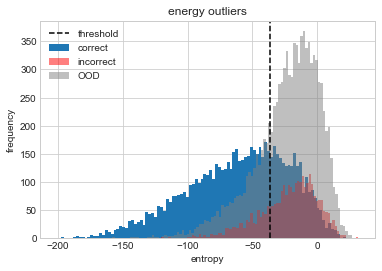

['exit_1']
m energy
metric energy
energy  lr_auc 0.13716306833720102 Best Threshold=-62.65158462524414, G-Mean=0.7893487225778709, TPR=0.8343357025697102, FPR=0.25321258107942723


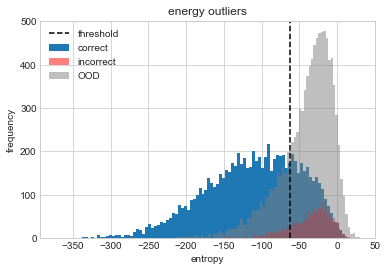

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15272443336451527 Best Threshold=-2.4557578563690186, G-Mean=0.7728372610411698, TPR=0.8432518597236982, FPR=0.2916974624291698


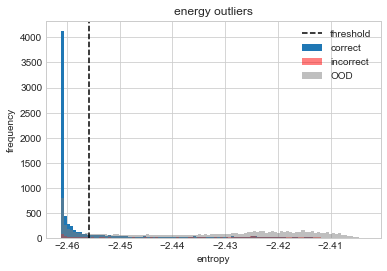

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7164  -36.56374         5651          2532              4968           0.690578             0.607112
1     exit_2       4349        7468         0.8171 -62.651585         1924          1383              1745           0.581796             0.527669
2  Main_exit       2425        6085         0.8118         NA         2425          6085              1435           0.284959             0.168625


In [20]:
#EDL IAR, e15, g100
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean",plot=True)

In [17]:
#CE not frozen 15e all softmax
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["calibration"], "gmean", main_exit_included=True,plot=False)

metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.18461562362569073 Best Threshold=0.07747278362512589, G-Mean=0.7449641960374295, TPR=0.7936241610738255, FPR=0.3007122507122507
['exit_1']
m entropy
metric entropy
entropy  lr_auc 0.14399299565265905 Best Threshold=0.31188473105430603, G-Mean=0.7857228321936769, TPR=0.8168859649122807, FPR=0.24425146771037182
['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.13081956534546435 Best Threshold=3.234389543533325, G-Mean=0.7931292079843568, TPR=0.8633811603243917, FPR=0.27140645468619745
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7020  0.077473         5525          2676              4909           0.673698             0.598586
1     exit_2       4475        7324         0.8176  0.311885         2053          1655              1863           0.553668    

metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.18340613291238456 Best Threshold=0.10762191563844681, G-Mean=0.7465706388344123, TPR=0.7791270101739416, FPR=0.28462534157917446


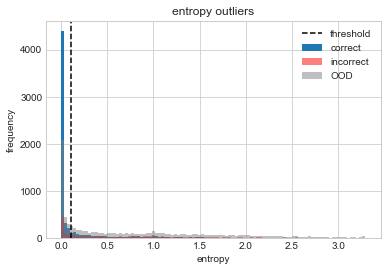

['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.14205042812394303 Best Threshold=0.37969541549682617, G-Mean=0.7875523493994728, TPR=0.8499147242751564, FPR=0.2702341948792622


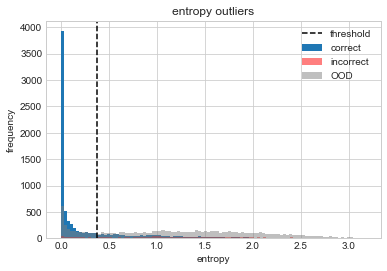

['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.1512680089176477 Best Threshold=0.5028960704803467, G-Mean=0.7796055318423997, TPR=0.8234075608493009, FPR=0.26186640228033214


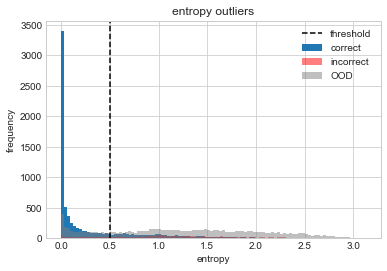

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6953  0.107622         5648          2912              4974           0.659813             0.581075
1     exit_2       4352        7088         0.8241  0.379695         1898          1199              1754           0.612851             0.566355
2  Main_exit       2454        5889         0.8069        NA         2454          5889              1411           0.294139             0.169124


In [36]:
#CE not frozen 15e all softmax
evaluate.buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean",plot=True)


metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.21397379004733222 Best Threshold=-54.819976806640625, G-Mean=0.7149640453472197, TPR=0.7339382940108893, FPR=0.30351966873706004


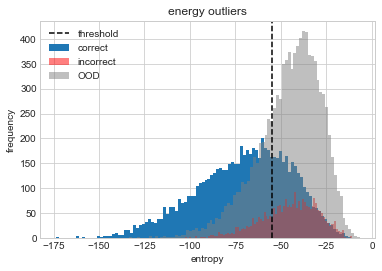

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15335865420564687 Best Threshold=-86.49794006347656, G-Mean=0.7733408343923627, TPR=0.8178896625602571, FPR=0.26878150743882945


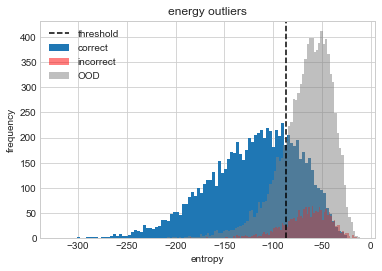

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15272446609114917 Best Threshold=-2.4557576179504395, G-Mean=0.7728372610411698, TPR=0.8432518597236982, FPR=0.2916974624291698


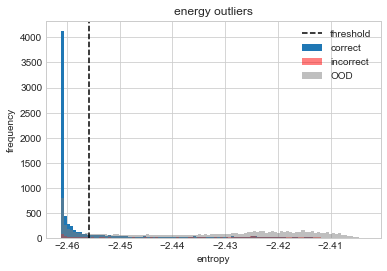

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7245 -54.819977         5780          2656              5046           0.685159             0.598151
1     exit_2       4220        7344         0.8133  -86.49794         1742          1063              1572           0.621034             0.560428
2  Main_exit       2478        6281         0.8118         NA         2478          6281              1472           0.282909             0.168056


In [47]:
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean",plot=True)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.21234653131877088 Best Threshold=-51.00204086303711, G-Mean=0.7171848917992476, TPR=0.7332605531295487, FPR=0.29853833425261994


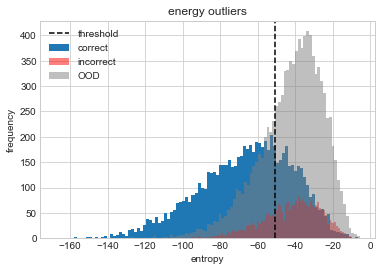

['exit_1']
m energy
metric energy
energy  lr_auc 0.15453993971107588 Best Threshold=-87.03630065917969, G-Mean=0.7740264185086823, TPR=0.8279329608938547, FPR=0.2763702801461632


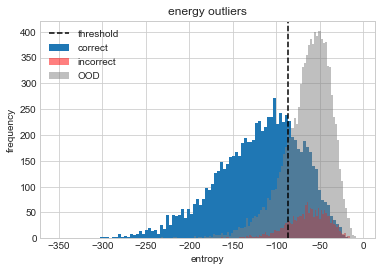

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15272446609114917 Best Threshold=-2.4557576179504395, G-Mean=0.7728372610411698, TPR=0.8432518597236982, FPR=0.2916974624291698


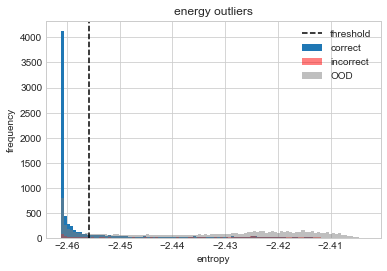

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7252 -51.002041         5821          2662              5087           0.686196             0.599670
1     exit_2       4179        7338         0.8210 -87.036301         1703          1041              1552           0.620627             0.565598
2  Main_exit       2476        6297         0.8118         NA         2476          6297              1444           0.282230             0.164596
metric:  uncert threshold:  gmean
m uncert
metric uncert
uncert  lr_auc 0.2211779554262399 Best Threshold=0.0389309823513031, G-Mean=0.7076014428559815, TPR=0.764919941775837, FPR=0.34542195256480973


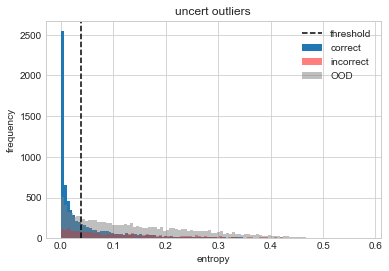

['exit_1', 'exit_2']
m uncert
metric uncert
uncert  lr_auc 0.18922811804652998 Best Threshold=0.0016670763725414872, G-Mean=0.771057652123424, TPR=0.8178770949720671, FPR=0.2730816077953715


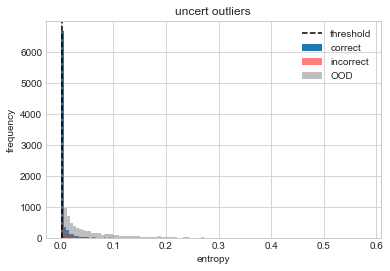

['exit_1', 'exit_2']
m uncert
metric uncert
uncert  lr_auc 0.1530755574196646 Best Threshold=0.4973944425582886, G-Mean=0.7727822515163869, TPR=0.8400637619553666, FPR=0.28911061837891106


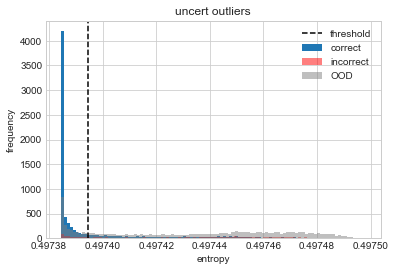

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7252  0.038931         5394          2335              4747           0.697891             0.614180
1     exit_2       4606        7665         0.8210  0.001667         2007          1152              1826           0.635328             0.578031
2  Main_exit       2599        6513         0.8118        NA         2599          6513              1520           0.285228             0.166813


In [29]:
#EDL no kl, info, frozen 15e
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean",plot=True)
buildComparePlot(output_ID, output_OOD, ["uncert"], "gmean",plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.20113991222570532 Best Threshold=-41.47420883178711, G-Mean=0.727333774867286, TPR=0.7545454545454545, FPR=0.2988965517241379


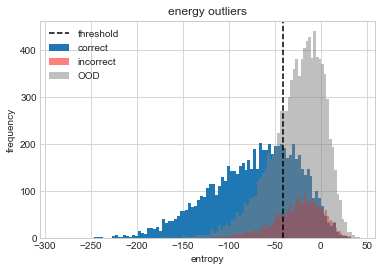

['exit_1', 'exit_2']
energy  lr_auc 0.14100472770938702 Best Threshold=-41.509281158447266, G-Mean=0.7856180375511123, TPR=0.7976190476190477, FPR=0.22620240480961923


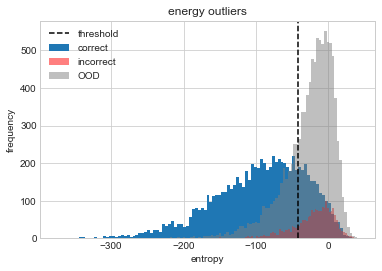

['exit_1', 'exit_2']
energy  lr_auc 0.15272446609114917 Best Threshold=-2.4557576179504395, G-Mean=0.7728372610411698, TPR=0.8432518597236982, FPR=0.2916974624291698


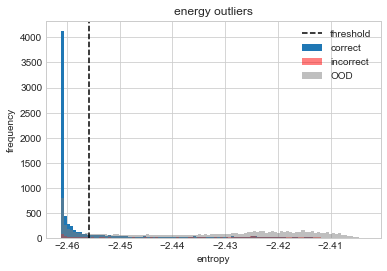

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7250 -41.474209         5759          2665              5083           0.683642             0.603395
1     exit_2       4241        7335         0.7984 -41.509281         1964          1625              1724           0.547228             0.480357
2  Main_exit       2277        5710         0.8118         NA         2277          5710              1351           0.285088             0.169150
metric:  uncert threshold:  gmean
uncert  lr_auc 0.20357971159874608 Best Threshold=0.1270369589328766, G-Mean=0.7264560430233484, TPR=0.7585454545454545, FPR=0.3042758620689655


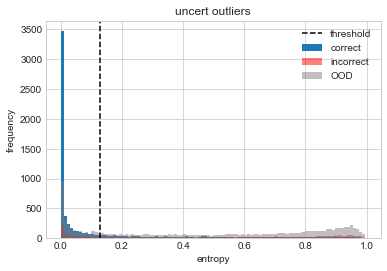

['exit_1', 'exit_2']
uncert  lr_auc 0.14378098955848206 Best Threshold=0.12290427088737488, G-Mean=0.7853181014528511, TPR=0.8045634920634921, FPR=0.23346693386773548


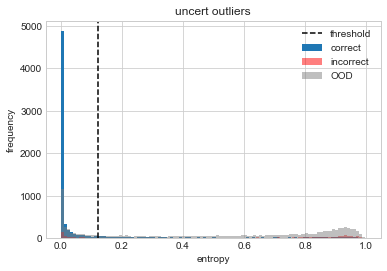

['exit_1', 'exit_2']
uncert  lr_auc 0.1530755574196646 Best Threshold=0.4973944425582886, G-Mean=0.7727822515163869, TPR=0.8400637619553666, FPR=0.28911061837891106


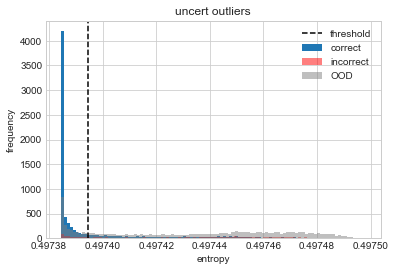

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7250  0.127037         5709          2603              5044           0.686838             0.606833
1     exit_2       4291        7397         0.7984  0.122904         1965          1592              1727           0.552432             0.485522
2  Main_exit       2326        5805         0.8118        NA         2326          5805              1386           0.286066             0.170459


In [37]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["uncert"], "gmean",plot=True)

metric:  energy threshold:  gmean
energy  lr_auc 0.1907121703959383 Best Threshold=-57.2607307434082, G-Mean=0.7385834089377541, TPR=0.7697461212976022, FPR=0.2913176996091569


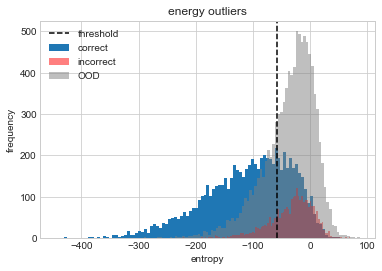

['exit_1', 'exit_2']
energy  lr_auc 0.12754790694163093 Best Threshold=-69.93891906738281, G-Mean=0.8017087511655032, TPR=0.8378212974296205, FPR=0.23284723882381067


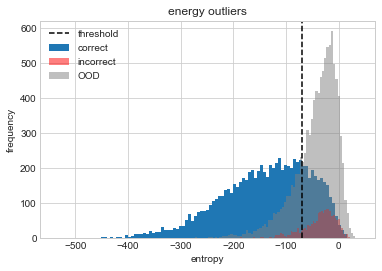

['exit_1', 'exit_2']
energy  lr_auc 0.15272446609114917 Best Threshold=-2.4557576179504395, G-Mean=0.7728372610411698, TPR=0.8432518597236982, FPR=0.2916974624291698


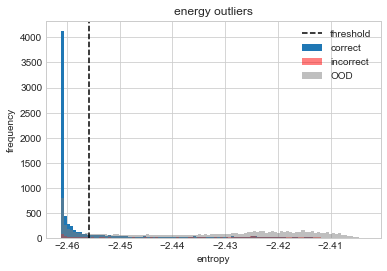

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7164 -57.260731         5731          2698              5077           0.679915             0.602325
1     exit_2       4269        7302         0.8366 -69.938919         1996          1250              1854           0.614911             0.571165
2  Main_exit       2273        6052         0.8118         NA         2273          6052              1276           0.273033             0.153273


In [74]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",plot=True)

metric:  entropy threshold:  gmean
entropy  lr_auc 0.19500973172018346 Best Threshold=0.10425099730491638, G-Mean=0.7334141616843567, TPR=0.7839602113770594, FPR=0.3138729175880879


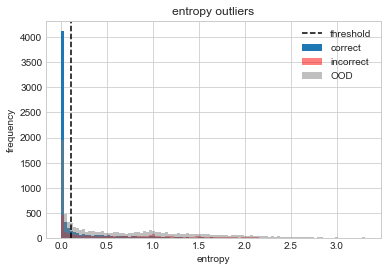

['exit_1']
entropy  lr_auc 0.14352621345149252 Best Threshold=0.548163890838623, G-Mean=0.7847019316079521, TPR=0.8295987493486191, FPR=0.2577651280782081


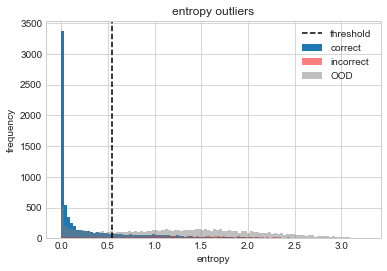

['exit_1', 'exit_2']
entropy  lr_auc 0.15268260872638675 Best Threshold=3.226457118988037, G-Mean=0.7728117682763362, TPR=0.8437832093517534, FPR=0.292190194629219


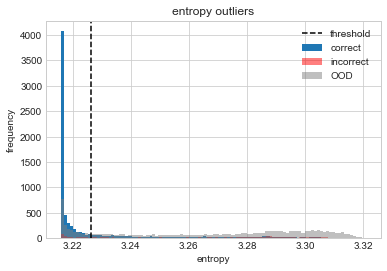

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6783  0.104251         5350          2794              4654           0.656925             0.571464
1     exit_2       4650        7206         0.8081  0.548164         2185          1498              1981           0.593266             0.537877
2  Main_exit       2465        5708         0.8118        NA         2465          5708              1477           0.301603             0.180717
metric:  calibration threshold:  gmean
calibration  lr_auc 0.80372368504688 Best Threshold=0.9890165328979492, G-Mean=0.7338456519359043, TPR=0.6812619784756008, FPR=0.20951196767174385


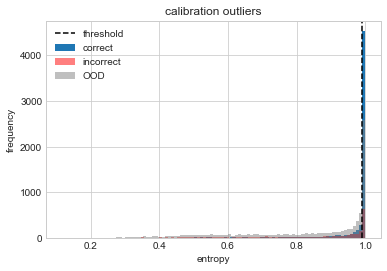

['exit_1', 'exit_2']
calibration  lr_auc 0.8582722459846528 Best Threshold=0.893603503704071, G-Mean=0.7825446306637244, TPR=0.7557233015715876, FPR=0.18968212610734758


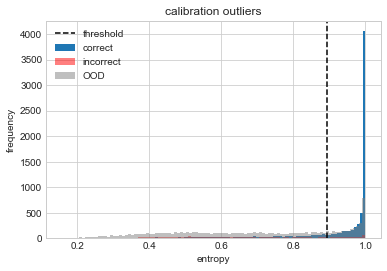

['exit_1', 'exit_2']
calibration  lr_auc 0.8473543069166563 Best Threshold=0.22421382367610931, G-Mean=0.7729161477751264, TPR=0.7111357477211135, FPR=0.15993623804463336


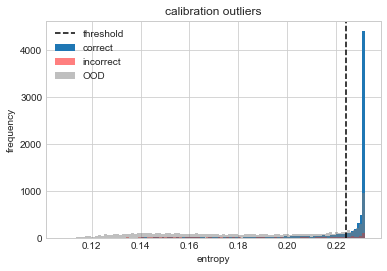

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6783  0.989017         5295          2750              4621           0.658173             0.574394
1     exit_2       4705        7250         0.8081  0.893604         2300          1689              2072           0.576586             0.519428
2  Main_exit       2405        5561         0.8118        NA         2405          5561              1436           0.301908             0.180266


In [19]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",plot=True)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "gmean",plot=True)

In [25]:
def calc_auc_OOD(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],main_exit_included=True, OOD_rate=[.1,.2,.5,1], plot=True,exit_labels=['exit_1']):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            Exit_Name=[]
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            if main_exit_included:
                _ID.append(_ID.pop(0))
                _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            # Branch_cost =[17443270,29419724,132134023] #flat exit costs
            # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

            # Base_cost = 112698838
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            for rate in OOD_rate:
                # print(int(min((len(_output_ID) * i),len(_output_ID))))
                print("OOD size",rate)
                _OOD_frac=[]
                Exit_Name=[]
                rollOver_ID_indices = pd.Index([])
                rollOver_OOD_indices = pd.Index([])
                Input_ID=[]
                Input_OOD=[]
                Accepted_list =[]
                Accepted_ID_list = []
                Accepted_OOD_list = []
                Acceptance_correct =[]
                Input_predictions =[]
                Accepted_Ratio_list=[]
                Accepted_Accuracy_list=[]
                # Branch_cost =[17443270,29419724,132134023] #flat exit costs
                # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

                # Base_cost = 112698838
                Branch_flops = []
                Thresholds=[]
                Test_accuracy =[]
                Rollover_accuracy=[]
                Results=[]
                for i, output in enumerate(_OOD):
                    
                    amount = min(len(_ID[i]) * rate,len(_ID[i]))
                    # print("len",amount)
                    _OOD_frac.append(_OOD[i].iloc[0:int(amount)])
                    # print(len(_OOD_frac[i]),len(_ID[i]))
                # _df = pd.concat([_ID,_OOD], ignore_index=True)
                # y_true = np.int32(_df['outlier'])
                for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD_frac)): 
                    Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))

                    legend = ["threshold","correct","incorrect", "OOD"]
                    Correct = output_ID.loc[(output_ID['correct'] == True)]
                    Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                    if plot:
                        _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                        _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                        _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram


                    if threshold:
                        if type(threshold) is list:
                            if j >= len(threshold): #no threshold in the array so treat as None.
                                continue
                            _threshold = threshold[j]
                        else:
                            _threshold = threshold
                        if _threshold == "mean":
                            # _threshold = np.array(ID[metric]).mean()
                            Correct = output_ID.loc[(output_ID["correct"] == True)]
                            _threshold = np.array(Correct[metric]).mean()
                        if _threshold == "gmean":
                            AUC_thresholds = evaluate.calc_AUC(output_ID, metrics=metrics,plot = False)
                            _threshold = AUC_thresholds[j]
                        if _threshold == "PR_AUC":
                            precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                            _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                        else:
                            _threshold = np.float32(_threshold)

                    if len(rollOver_ID_indices)>0:
                        # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                        output_ID = output_ID.iloc[rollOver_ID_indices]
                    if len(rollOver_OOD_indices)>0:
                        # if plot:
                        # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                        output_OOD = output_OOD.iloc[rollOver_OOD_indices]

                    if plot:
                        plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                        plt.title(metric + " outliers")
                        plt.legend(legend)
                        plt.xlabel("entropy")
                        plt.ylabel("frequency")
                        plt.show()
                    if main_exit_included and i == len(_ID)-1 :
                        Exit_Name.append("Main_exit")
                        _threshold
                        if plot:
                            print("main_exit")
                        OOD_accepted = output_OOD
                        OOD_rejected = None
                        ID_accepted = output_ID
                        ID_rejected = None
                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = None
                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = None
                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        _threshold = "NA"
                        ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                        # if metric in lessThanMetrics:
                            # _threshold = math.inf
                        # else:
                            # _threshold = -math.inf
                    # print(_threshold)
                    else:
                        if metric in lessThanMetrics: ## metrics that require less than metric
                            OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                            OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                            ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                            ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                            accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                            rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                            accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                            rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                            # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                            # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                            # print("overall Accepted acc:",(overall_accepted_acc))

                            # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                            # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                            # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                        else: ### metrics that require greater than metric
                            OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                            OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                            ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                            ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                            accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                            rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                            accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                            rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                            # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                            # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                            # print("overall Accepted acc:",(overall_accepted_acc))

                            # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                            # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                            # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                        rollOver_ID_indices = ID_rejected.index
                        rollOver_OOD_indices = OOD_rejected.index
                        if i >= len(exit_labels):
                            exit_labels.append("exit_{}".format(i+1))
                        print(exit_labels)
                        Exit_Name.append(exit_labels[i])
                    Thresholds.append(_threshold)

                    Results.append(accepted_correct +accepted_incorrect)
                    Input_ID.append(len(output_ID))
                    Input_OOD.append(len(output_OOD))
                    Accepted_ID_list.append(len(ID_accepted))
                    Accepted_OOD_list.append(len(OOD_accepted))
                    Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted)+ len(OOD_accepted)))
                    Acceptance_correct.append(len(accepted_correct))
                    Accepted_Accuracy_list.append(overall_accepted_acc)
                df = pd.DataFrame({
                "Exit_Name":Exit_Name,
                "ID_Inputs":Input_ID,
                "OOD_Inputs":Input_OOD,
                "Test_Accuracy":Test_accuracy,
                # "RollOver_Accuracy":Rollover_accuracy,
                "Threshold":Thresholds,
                "Accepted ID":Accepted_ID_list,
                "Accepted OOD":Accepted_OOD_list,

                "Accepted_Correct":Acceptance_correct,
                "Accepted_ID_Ratio":Accepted_Ratio_list,
                "Acceptance_Accuracy":Accepted_Accuracy_list,

                # "Flops":Branch_flops,
                # "Cost Ratio":,                                  
                              })
                with pd.option_context('expand_frame_repr', False):
                    print (df)
                # print("TPR_ID-OOD",len(ID_accepted)/(len(ID_accepted) + len(ID_rejected)))
                # print("TPR_acc",len(accepted_correct)/(len(accepted_correct) + len(rejected_correct)))
                # if len(OOD) > 0:
                #     print("FPR_ID-OOD",len(OOD_accepted)/(len(OOD_accepted) + len(OOD_rejected)))
                # else: 
                #     print("FPR for OOD is div by zero, was OOD included?")
                # print("FPR_acc",len(accepted_incorrect)/(len(accepted_incorrect) + len(rejected_incorrect)))


In [20]:
calc_auc_OOD(output_ID, output_OOD, ["entropy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)


metric:  entropy threshold:  gmean
OOD size 0.1
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.6953  3.219826         5686           314              5002           0.947667             0.833667
1     exit_2       4314         686         0.8241  3.234338         1965           133              1796           0.936606             0.856053
2  Main_exit       2349         553         0.8069        NA         2349           553              1345           0.809442             0.463473
OOD size 0.2
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        2000         0.6953  3.219826         5686           615              5002           0.902396 

In [16]:
calc_auc_OOD(output_ID, output_OOD, ["energy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)

metric:  energy threshold:  gmean
OOD size 0.1
['exit_1']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.7164 -36.563728         5651           268              4968           0.954722             0.839331
1     exit_2       4349         732         0.8171 -62.651455         1924           130              1745           0.936709             0.849562
2  Main_exit       2425         602         0.8118         NA         2425           602              1435           0.801123             0.474067
OOD size 0.2
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        2000         0.7164 -36.563728         5651           518              4968           0.916032      

In [26]:
calc_auc_OOD(output_ID, output_OOD, ["energy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)

metric:  energy threshold:  gmean
OOD size 0.1
energy  lr_auc 0.20145986774623492 Best Threshold=-31.09141731262207, G-Mean=0.7272401739380328, TPR=0.7848605577689243, FPR=0.32615002072109406
['exit_1']
energy  lr_auc 0.13186150588225892 Best Threshold=-75.5687026977539, G-Mean=0.7927039477245751, TPR=0.8155397390272835, FPR=0.22949242242001444
['exit_1', 'exit_2']
energy  lr_auc 0.1460508204132312 Best Threshold=-2.444079875946045, G-Mean=0.7852319061190286, TPR=0.804028307022319, FPR=0.23312507656498835
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.7239 -31.091417         5473           239              4878           0.958158             0.853992
1     exit_2       4527         761         0.8314 -75.568703         2214           151              2020           0.936152             0.854123
2  Main_exit       2313         610         0.81

In [68]:
calc_auc_OOD(output_ID, output_OOD, ["energy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)

metric:  energy threshold:  gmean
OOD size 0.1
energy  lr_auc 0.20537788382132005 Best Threshold=-63.80274963378906, G-Mean=0.7259342833338003, TPR=0.7800815771583957, FPR=0.32445451969396427
['exit_1', 'exit_2']
energy  lr_auc 0.13942239387404648 Best Threshold=-65.24369049072266, G-Mean=0.7855681497408589, TPR=0.8382109331860851, FPR=0.2637684698986445
['exit_1', 'exit_2']
energy  lr_auc 0.15272446609114917 Best Threshold=-2.4557576179504395, G-Mean=0.7728372610411698, TPR=0.8432518597236982, FPR=0.2916974624291698
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.7058 -63.80275         5416           243              4768           0.957060             0.842552
1     exit_2       4584         757         0.8189 -65.24369         2062           103              1885           0.952425             0.870670
2  Main_exit       2522         654    

## Entropy Branch version
Now we build a branched model with the entropy metric and cross entropy loss for comparision.
<hr>

In [55]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()

lambda_callback = lambda_update(1000,0,max_t = 0.01)
# branch_loss = brevisEnergy(lambda_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# loss = kl_loss(lambda_callback)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)


model = brevis.BranchModel(name="./models/wideresnet_.81.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv1,_branch_conv2],
                          ["activation_83","activation_91",#"mixed6"
                          ],
                          target_input=False,loop=False,num_outputs=10)
# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                  # optimizer="adam",
              preset="", metrics=['accuracy'])

model.summary()


Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  activation_83
add Branch to branch point  activation_91
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_3')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x0000016FCBBD7388>

preset: Other
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                               

In [56]:
model.fit(train_ds, epochs = 5, validation_data=validation_ds, transfer=True,callbacks=[lambda_callback])

Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0
Epoch 1/5
1407/1407 [==============================] - 278s 195ms/step - loss: 2.4611 - dense_3_loss: 0.1722 - branch_exit_loss: 1.1862 - branch_exit_1_loss: 0.7447 - dense_3_accuracy: 0.9417 - branch_exit_accuracy: 0.6133 - branch_exit_1_accuracy: 0.7422 - val_loss: 1.9256 - val_dense_3_loss: 0.1696 - val_branch_exit_loss: 0.8319 - val_branch_exit_1_loss: 0.5699 - val_dense_3_accuracy: 0.9412 - val_branch_exit_accuracy: 0.7062 - val_branch_exit_1_accuracy: 0.8080
annealing coef updated to: 0.001
Epoch 2/5
1407/1407 [==============================] - 276s 196ms/step - loss: 1.6505 - dense_3_loss: 0.1219 - branch_exit_loss: 0.7380 - branch_exit_1_loss: 0.4402 - dense_3_accuracy: 0.9618 - branch_exit_accuracy: 0.7438 - branch_exit_1_accuracy: 0.8479 - val_loss: 1.7529 - val_dense_3_loss: 0.1534 - val_branch_exit_loss: 0.7498 - val_branch_exit_1_loss: 0.5030 - val_dense_3_accuracy: 0.9468 - val_br

In [57]:
model.evaluate(test_ds)

313/313 [==============================] - 19s 59ms/step - loss: 1.9134 - dense_3_loss: 0.4517 - branch_exit_loss: 0.6131 - branch_exit_1_loss: 0.5233 - dense_3_accuracy: 0.8630 - branch_exit_accuracy: 0.7911 - branch_exit_1_accuracy: 0.8391


[1.9133697748184204,
 0.45171138644218445,
 0.6130933165550232,
 0.5233008861541748,
 0.8629999756813049,
 0.791100025177002,
 0.8391000032424927]

In [58]:
model.save("./models/journal_models/wideresnet_B_conv3_5.hdf5")

## Get the Branch output results
Collect the branch output results for both the ID and OOD test sets then evaluate the results.

In [59]:
output_ID_old= evaluate.getPredictions_Energy(model, test_ds,stopping_point=None)
for i in output_ID_old:
    i['outlier']=0


outputs 3


In [60]:
output_OOD_old = evaluate.getPredictions_Energy(model, test_ds100,stopping_point=None)
for i in output_OOD_old:
    i['correct']=0
    i['outlier']=1

outputs 3


In [63]:
def save_outputs(filename,outputs):
    from openpyxl import Workbook
    wb= Workbook()
    ws=wb.active
    with pd.ExcelWriter('./csv/'+filename+'.xlsx', engine="openpyxl") as writer:
        writer.book=wb
        writer.sheets = dict((ws.title, ws) for ws in wb.worksheets)

        #useful code
        for i, df in enumerate(outputs):
            name = "exit{}".format(i+1)
            df.to_excel(writer, name)
        # df.to_excel(writer, sheet, ...)
        writer.save()
    wb.close()
    
def read_outputs(fileName):
    output_test = list(pd.read_excel('./csv/'+fileName+'.xlsx',['exit1','exit2','exit3']).values())
    # for i in output_test:
        # print(i.head())
    return output_test
filename = 'wideresnet_B_conv3_5'
save_outputs(filename+'_ID',output_ID_old)
save_outputs(filename+'_OOD',output_OOD_old)
# save_outputs(filename+'_OOD_SVHN',output_OOD_SVHN)

### T/F in distribution performance
<hr>

metric:  energy threshold:  mean
['exit_1', 'exit_2']
3766 inputs accepted 3546 Correct


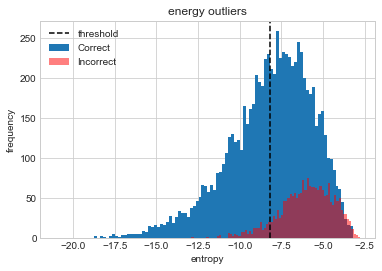

-----------------
rollover enabled, 6234 predictions provided
['exit_1', 'exit_2']
890 inputs accepted 856 Correct


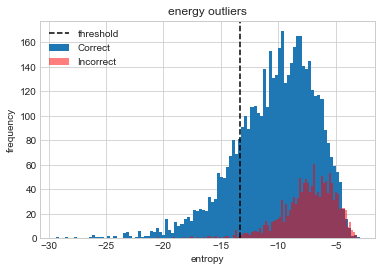

-----------------
rollover enabled, 5344 predictions provided
main_exit
5344 inputs accepted 4133 Correct


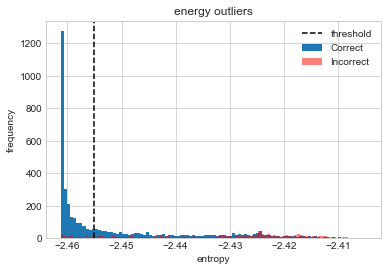

-----------------
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7911           0.791100  -8.180323      3766              3546        0.376600             0.941583
1     exit_2         6234         0.8391           0.769811 -13.332321       890               856        0.142765             0.961798
2  Main_exit         5344         0.8630           0.773391  -2.455151      5344              4133        1.000000             0.773391


In [64]:
evaluate.calculateBranching(output_ID_old,threshold="mean",metrics=["energy"],main_exit_included=True,plot=True)


In [67]:
evaluate.calculateBranching(output_ID_old,threshold="PR_AUC",metrics=["entropy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID_old,threshold="mean",metrics=["entropy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID_old,threshold="gmean",metrics=["entropy"],main_exit_included=True,plot=False)


metric:  entropy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7911           0.791100   0.082291      2090              2074        0.209000             0.992344
1     exit_2         7910         0.8391           0.798609   0.000280       467               467        0.059039             1.000000
2  Main_exit         7443         0.8630           0.817815   3.216030      7443              6087        1.000000             0.817815
metric:  entropy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7911           0.791100   0.575167      5029              4821        0.502900             0.958640
1     exit_2         4971     

### ID/OOD branch performance
<hr>

In [66]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["entropy"], "PR_AUC",plot=False)
evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["entropy"], "mean",plot=False)
evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["entropy"], "gmean",plot=False)

# buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "PR_AUC",plot=False)

metric:  entropy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7911  0.082291         2090           198              2074           0.913462             0.906469
1     exit_2       7910        9802         0.8391   0.00028          467            31               467           0.937751             0.937751
2  Main_exit       7443        9771         0.8630        NA         7443          9771              6087           0.432381             0.353608
metric:  entropy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7911  0.575167         5029          1397              4821           

In [ ]:
calc_auc_OOD(output_ID_old, output_OOD_old, ["entropy"], "mean",OOD_rate=[.1,.2,.5,1],plot=False)


### Calibration 
<hr>

In [ ]:
evaluate.calculateBranching(output_ID_old,threshold="PR_AUC",metrics=["calibration"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID_old,threshold="mean",metrics=["calibration"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID_old,threshold="gmean",metrics=["calibration"],main_exit_included=True,plot=False)


metric:  calibration threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7911           0.791100   0.614095      7911              6945        0.791100             0.877892
1     exit_2         2089         0.8391           0.626137   0.763845      1256               951        0.601245             0.757166
2  Main_exit          833         0.8630           0.579832   0.181627       833               483        1.000000             0.579832
metric:  calibration threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7911           0.791100   0.866677      5553              5265        0.555300             0.948136
1     exit_2         4

In [69]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["calibration"], "PR_AUC",plot=False)
evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["calibration"], "mean",plot=False)
evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["calibration"], "gmean",plot=False)

# buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "PR_AUC",plot=False)

metric:  calibration threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7911  0.614095         7911          5239              6945           0.601597             0.528137
1     exit_2       2089        4761         0.8391  0.763845         1256          1994               951           0.386462             0.292615
2  Main_exit        833        2767         0.8630        NA          833          2767               483           0.231389             0.134167
metric:  calibration threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7911  0.866677         5553          1932              5265   

In [74]:
calc_auc_OOD(output_ID_old, output_OOD_old, ["calibration"], "mean",OOD_rate=[.1,.2,.5,1],plot=True)


NameError: name 'calc_auc_OOD' is not defined